## Config

In [1]:
# parameters
SAVE_OUTPUT = True
SIZE_PLOTS = (12,10)
BUFFER_SIZE = 402.336 
YEARS = [2017,2018,2019,2020,2021,2022,2023]

#Location of the data
INPUT_DATA_PATH = "../data/interim/"
OUTPUTS = "../reports/figures/"

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import plotly.express as px
import plotly.figure_factory as ff



## Load data

In [3]:
cunters_list = []
#for year in years, load the data in counters_data{year}.parquet
for year in YEARS:
    #Load the data AADBT
    counters_data = pd.read_parquet(f"{INPUT_DATA_PATH}/flagged/AADBT_{year}.parquet")
    counters_data["year"]=year

    #Load the data stations_data
    stations_data = gpd.read_parquet(f"{INPUT_DATA_PATH}/stations_data{year}.parquet")

    #Merge the data
    counters_data['Id_aforament'] = counters_data['Id_aforament'].astype(int)
    stations_data['Id_aforament'] = stations_data['Id_aforament'].astype(int)
    counters_data = pd.merge(counters_data, stations_data, on="Id_aforament")
    #Append the data to the list
    cunters_list.append(counters_data)
    
df = pd.concat(cunters_list)
gdf = gpd.GeoDataFrame(df, geometry='geometry')



## Data management

In [4]:
print(gdf.shape)
print(gdf.columns)
gdf.head()

(1267, 12)
Index(['Id_aforament', 'AADBT', 'Number_of_days', 'year', 'Desc_aforament',
       'Num_carrils', 'Codi_districte', 'Codi_barri',
       'Codi_tipus_equip_mesura', 'Desc_tipus_equip_mesura', 'geometry',
       'Codi_Barri'],
      dtype='object')


,Id_aforament,AADBT,Number_of_days,year,Desc_aforament,Num_carrils,Codi_districte,Codi_barri,Codi_tipus_equip_mesura,Desc_tipus_equip_mesura,geometry,Codi_Barri
0,20004,5218.805195,231,2017,GRAN VIA DE LES CORTS CATALANES - ARIBAU (carr...,1,2.0,8.0,1.0,Espira,POINT (2.16307 41.38537),NaN
1,20007,3303.042169,166,2017,ENRIC GRANADOS - MALLORCA (carril BICI),1,2.0,8.0,1.0,Espira,POINT (2.15938 41.38999),NaN
2,20008,3560.098039,255,2017,ENRIC GRANADOS - VALENCIA (carril BICI),1,2.0,8.0,1.0,Espira,POINT (2.15938 41.38999),NaN
3,20009,4464.252688,186,2017,CONSELL DE CENT - SARDENYA (carril BICI),1,2.0,5.0,1.0,Espira,POINT (2.17792 41.40020),NaN
4,20010,3133.890173,173,2017,PL. TETUAN - PG. SANT JOAN (carril BICI),1,2.0,5.0,1.0,Espira,POINT (2.17623 41.39554),NaN


In [5]:
#Split the data in various dataframes by year
gdf_2017 = gdf[gdf["year"]==2017]
gdf_2018 = gdf[gdf["year"]==2018]
gdf_2019 = gdf[gdf["year"]==2019]
gdf_2020 = gdf[gdf["year"]==2020]
gdf_2021 = gdf[gdf["year"]==2021]
gdf_2022 = gdf[gdf["year"]==2022]
gdf_2023 = gdf[gdf["year"]==2023]


# Maps

## Introduction

In [ ]:
fig5 = px.scatter_mapbox(gdf_2023, lat=gdf_2023.geometry.y, lon=gdf_2023.geometry.x, color_discrete_sequence=["red"])

colors = px.colors.qualitative.Plotly

for year, gdf_year in zip(reversed(YEARS[:-1]), [gdf_2022, gdf_2021, gdf_2020, gdf_2019, gdf_2018, gdf_2017]):
    color = colors[YEARS.index(year) % len(colors)]
    fig = px.scatter_mapbox(gdf_year, lat=gdf_year.geometry.y, lon=gdf_year.geometry.x, 
                            color_discrete_sequence=[color])
    for trace in fig.data:
        fig5.add_trace(trace)

fig5.update_layout(mapbox_style="carto-positron", mapbox_zoom=11, mapbox_center={"lat": gdf.geometry.y.mean(), "lon": gdf.geometry.x.mean()})
fig5.update_layout(    showlegend=False,legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig5.show()

C:\Users\lucal\AppData\Local\Temp\ipykernel_15952\3927810864.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



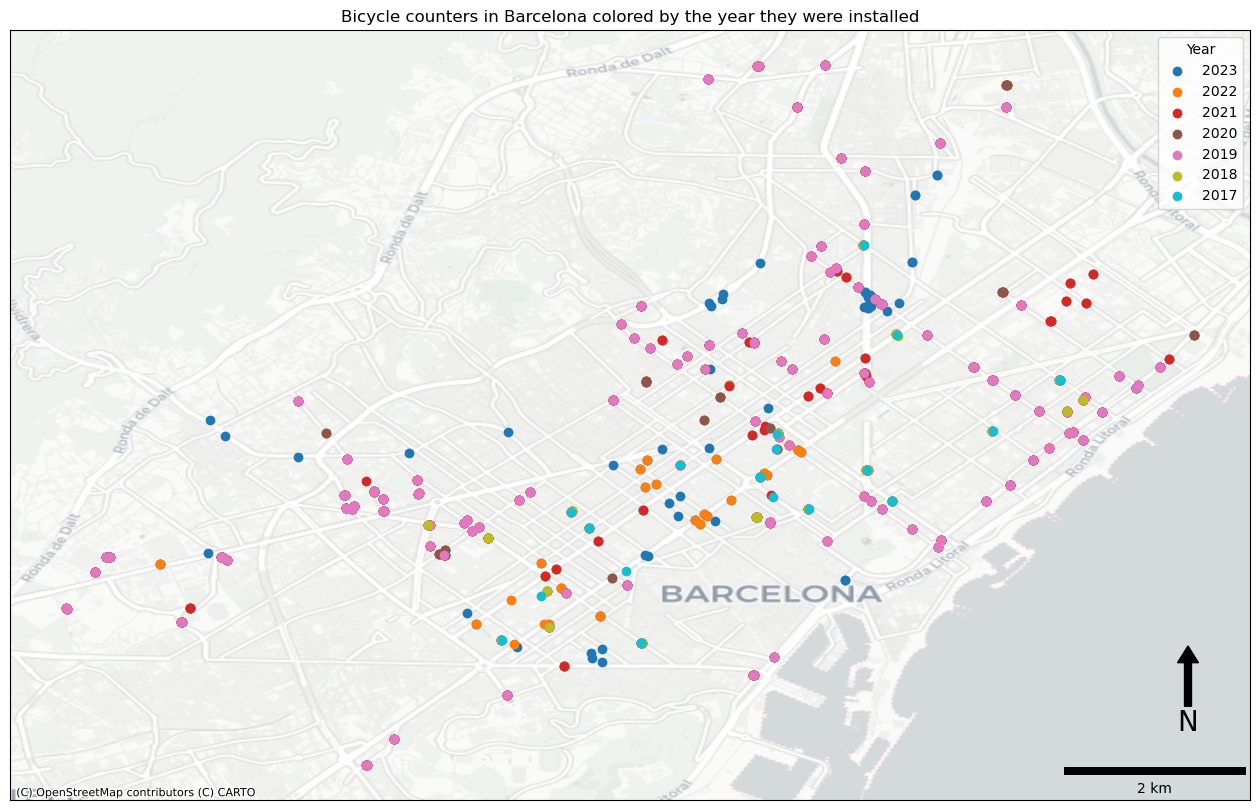

In [47]:
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 10))

# Define colors
colors = plt.cm.get_cmap('tab10', len(YEARS))

# Plot data for each year
for i, (year, gdf_year) in enumerate(zip(reversed(YEARS), [gdf_2023, gdf_2022, gdf_2021, gdf_2020, gdf_2019, gdf_2018, gdf_2017])):
    gdf_year = gdf_year.to_crs(epsg=3857)  # Use EPSG:3857 for web mercator projection
    ax.scatter(gdf_year.geometry.x, gdf_year.geometry.y, color=colors(i), label=str(year))

# Add basemap
ctx.add_basemap(ax, crs=gdf_year.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
scalebar = ScaleBar(dx=1, units='m', location='lower right', frameon=False)  # Set dx to 1 meter per pixel
ax.add_artist(scalebar)

# Add north arrow
x, y, arrow_length = 0.95, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# Set map style
ax.set_title('Bicycle counters in Barcelona colored by the year they were installed')
ax.set_axis_on()
ax.set_xticks([])
ax.set_yticks([])

# Add legend
ax.legend(title='Year')

# Save plot

# Show plot
plt.show()


In [7]:
fig = px.scatter_mapbox(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x, 
                        color="year", zoom=15, 
                        mapbox_style="carto-positron",
                        color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Basic

## Hexagons

In [8]:
fig4 = ff.create_hexbin_mapbox(
    data_frame=gdf, lat=gdf.geometry.y, lon=gdf.geometry.x,
    nx_hexagon=15, animation_frame="year",
    color_continuous_scale="Magma", 
    labels={"color": "AADBT", "year": "Year"},
    color="AADBT", agg_func=np.mean,
    opacity=0.5, min_count=1,
    show_original_data=True, original_data_marker=dict(opacity=0.6, size=4, color="deeppink")
)
fig4.update_layout(
    mapbox_style="carto-positron", 
    margin=dict(b=0, t=0, l=0, r=0),
    mapbox_zoom=12, 
    mapbox_center={"lat": gdf.geometry.y.mean(), "lon": gdf.geometry.x.mean()},
    title="Hexbin Mapbox of AADBT Data"
)
fig4.layout.sliders[0].pad.t = 20
fig4.layout.updatemenus[0].pad.t = 40
fig4.show()


## Save output

In [48]:
if SAVE_OUTPUT:
    Path(OUTPUTS).mkdir(parents=True, exist_ok=True)
    # fig1.write_html(f"{OUTPUT_DATA_PATH}/hexbin_mapbox.html")
    # fig2.write_html(f"{OUTPUT_DATA_PATH}/hexbin_mapbox_min_count.html")
    # fig3.write_html(f"{OUTPUT_DATA_PATH}/hexbin_mapbox_original_data.html")
    fig4.write_html(f"{OUTPUTS}/hexbin_mapbox_animation.html")
    fig5.write_html(f"{OUTPUTS}/hexbin_mapbox_animation2.html")
    plt.savefig(Path(OUTPUTS, 'bicycle_counters_barcelona.png'), bbox_inches='tight', dpi=300)
    print(f"Outputs saved in {OUTPUTS}")

Outputs saved in ../reports/figures/


<Figure size 640x480 with 0 Axes>

## Watermark

In [10]:
!python -m pip install watermark --quiet

In [11]:
%load_ext watermark

In [12]:
%watermark

Last updated: 2025-01-26T11:26:48.416012+01:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



In [13]:
%watermark --iversions

pandas   : 2.0.3
plotly   : 5.24.1
numpy    : 1.24.4
geopandas: 0.13.2



In [14]:
!lsb_release -a

"lsb_release" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
